# CNN

In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import Image

## 图解原理

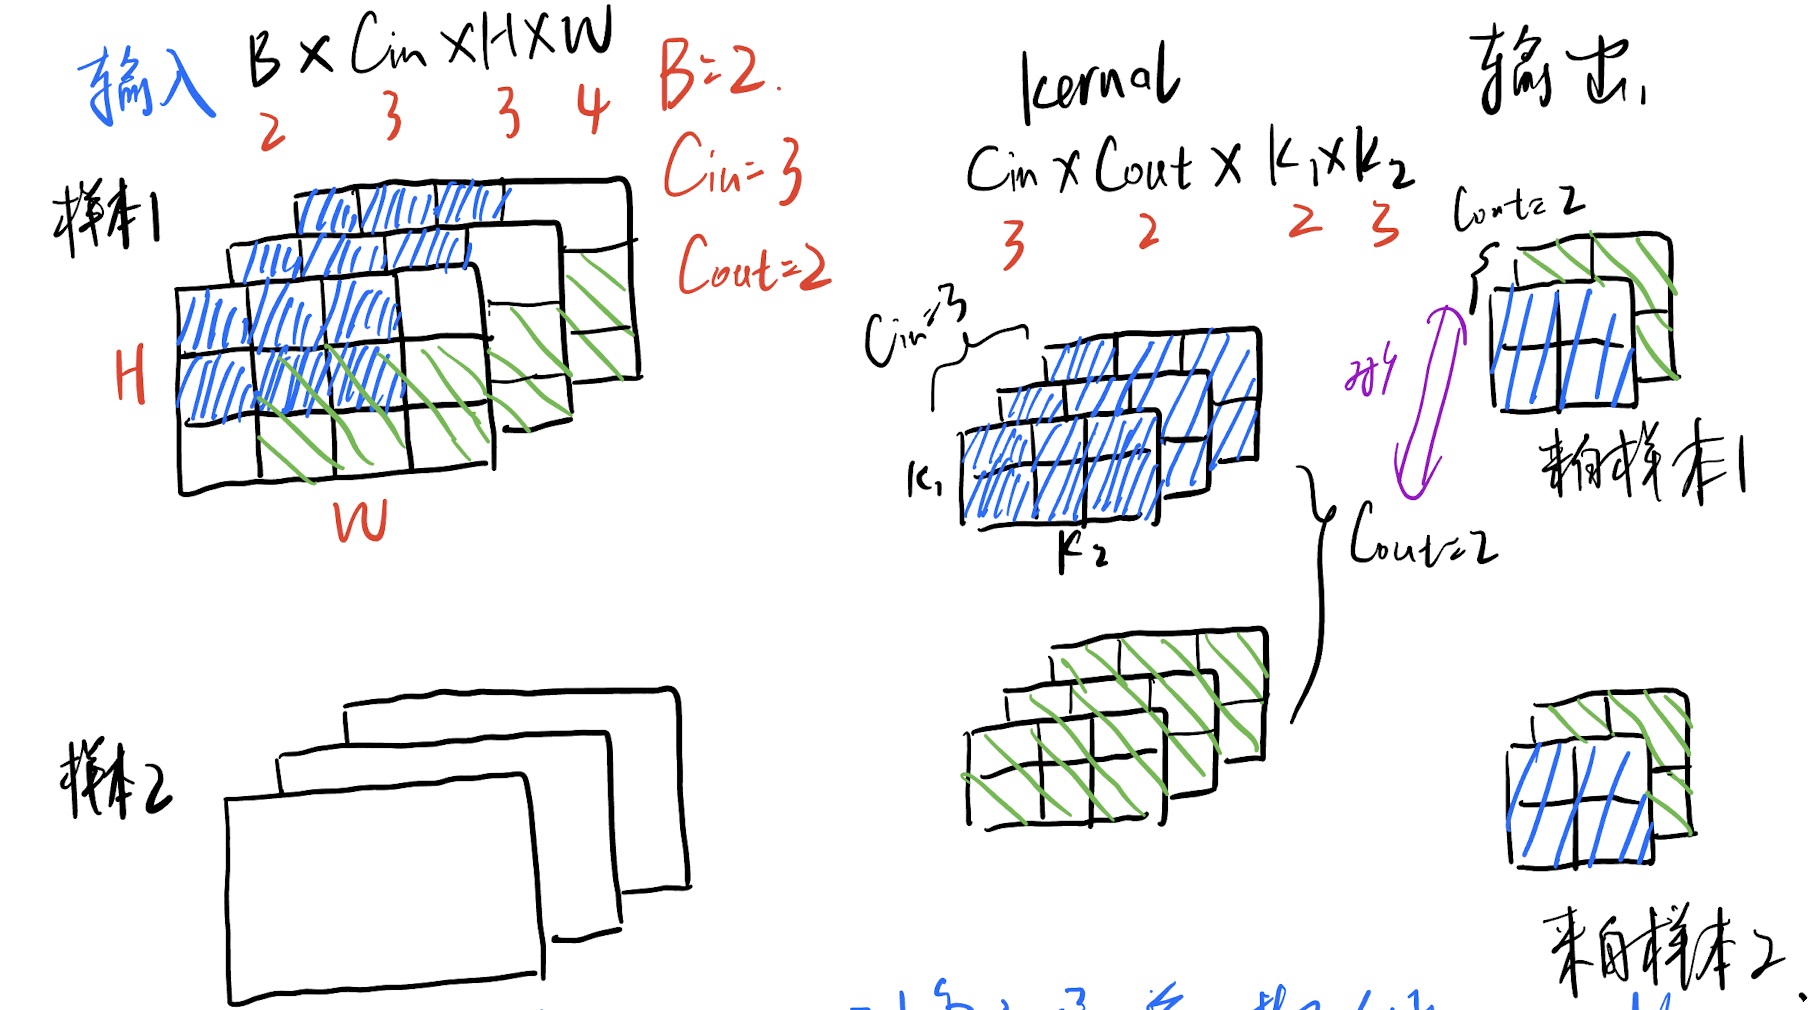

In [8]:
Image(filename='./data/CNN_inout.png')

这里的`B`代表`batch size`，`Cin`代表输入通道数，`H、W`代表每个通道的二维图像的高度和宽度

## 导入CIFAR10数据集

In [33]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = CIFAR10(root='./data', train=True, download=False, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = CIFAR10(root='./data', train=False, download=False, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## 数据集中的图片

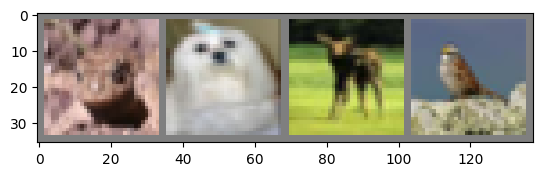

plane ship  ship  cat  


In [85]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
# 这里的iter函数将trainloader转换为迭代器。
# imsages, label获取的是迭代器的下一条数据，在这里也就是一个小批量
dataiter = iter(trainloader)
imsages, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## 查看一下训练集、测试集、小批量的shape

In [87]:
X_train_batch, y_train_batch = next(iter(trainloader))
X_test_batch, y_test_batch = next(iter(testloader))

In [82]:
# images是四维张量，这也是图像数据的一般形式，表示(批量大小，通道数，高度，宽度)。
# 通道数为3代表了RGB三原色，高度宽度均为32代表了每个图像是由32*32个像素点构成的
print(f' 训练集长度为{len(trainset)}, 测试集长度为{len(testset)}\n',
      f'总共分成了{len(trainloader)}个小批量, 每个小批量包含{len(X_train_batch)}个样本\n',
      f'训练集小批量中样本形状是{X_train_batch.shape}, 标签形状是{y_train_batch.shape}\n',
      f'测试集小批量中样本形状是{X_test_batch.shape}, 标签形状是{y_test_batch.shape}')

 训练集长度为50000, 测试集长度为10000
 总共分成了12500个小批量, 每个小批量包含4个样本
 训练集小批量中样本形状是torch.Size([4, 3, 32, 32]), 标签形状是torch.Size([4])
 测试集小批量中样本形状是torch.Size([4, 3, 32, 32]), 标签形状是torch.Size([4])


In [89]:
# y_train_batch(标签)代表classes中对应索引的类别
y_train_batch

tensor([3, 8, 2, 7])

In [90]:
classes

('plane',
 'car',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck')

## 定义一个CNN

* 对每个小批量的训练，输入形状为``
* `in_channels`代表输入的通道数，在此例中输入的通道数为3，则`in_channel`参数必须由输入的形状确定，否则会报错。即：`我们需要保证 in_channels = input.shape[1]`
* `out_channels`代表输出的通道数，对于四维张量，核函数有几个矩阵组，就有几个输出通道，输出通道数量可以指定。
* 如果输入样本的批量大小大于1，则对于每一个输入的样本，都会进行一次卷积。即输出的批量数 = 输入的批量数
output.shape[0] = input.shape[0]。
* Conv2d定义的核函数最多是一个四维张量，形状为`(输出通道数Cin, 输入通道数Cout，卷积核高度k1，卷积核跨度k2)`。


In [176]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(5, 5), stride=1)  # 输入通道为3，输出通道为6
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5), stride=1)  # 输入通道为6，输出通道为16
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # 最终的输出的形状：(样本数, 10), 10代表分类问题的类别数
        return x

    # def forward(self, x):
        
    #     # 卷积部分
    #     ## 第一个卷积层
    #     print('=====第一次卷积以及汇聚运算开始========')
    #     x = self.conv1(x)
    #     print("Output shape after conv1:", x.shape)  # 打印conv1层的输出形状
    #     x = F.relu(x)
    #     print("Output shape after relu1:", x.shape)  # 打印relu1层的输出形状
    #     ## 第一个最大汇聚层
    #     x = self.pool(x)
    #     print("Output shape after pool1:", x.shape)  # 打印pool1层的输出形状
    #     print('=====第一次卷积以及汇聚运算结束========\n')
        
        # ## 第二个卷积层
        # print('=====第二次卷积以及汇聚运算开始========')
        # x = self.conv2(x)
        # print("Output shape after conv2:", x.shape)  # 打印conv2层的输出形状
        # x = F.relu(x)
        # print("Output shape after relu2:", x.shape)  # 打印relu2层的输出形状
        # ## 第二个最大汇聚层
        # x = self.pool(x)
        # print("Output shape after pool2:", x.shape)  # 打印pool2层的输出形状
        # print('=====第二次卷积以及汇聚运算结束========\n')
                
        # # 卷积之后输出
        # x = torch.flatten(x, 1)
        # print("Output shape after flatten:", x.shape)  # 打印flatten层的输出形状
        # x = F.relu(self.fc1(x))
        # print("Output shape after fc1:", x.shape)  # 打印fc1层的输出形状
        # x = F.relu(self.fc2(x))
        # print("Output shape after fc2:", x.shape)  # 打印fc2层的输出形状
        # x = self.fc3(x)
        # print("Final output shape:", x.shape)  # 打印最终输出的形状
        # return x

cnn = CNN()
cnn(X_train_batch).shape

torch.Size([4, 10])

## 关于卷积核的形状

### Conv2d

In [3]:
# 定义四维张量输入(批量大小batch_size, 输入通道数Cin, 高度Height, 宽度Weight)
input = torch.randn(2, 3, 4, 5)
# 定义卷积核
m = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=(3, 2), stride=1)
print(input.shape, '\n', m)

torch.Size([2, 3, 4, 5]) 
 Conv2d(3, 4, kernel_size=(3, 2), stride=(1, 1))


In [158]:
name, param = next(iter(m.named_parameters()))
x = param.data
# 卷积层的形状:(out_channels, in_channels, kernel_size[0], kernel_size[1])
x.shape

torch.Size([4, 3, 3, 2])

In [159]:
# (batch_size, channel, height, width)
output = m(input)
output.shape

torch.Size([2, 4, 2, 4])

### Conv3d

input：<br>
batch_size = 2<br>
channel = 3<br>
length = 4<br>
width = 4<br>
height = 6

In [163]:
input = torch.randn(2, 3, 4, 4, 6)

In [164]:
m = nn.Conv3d(in_channels=3, out_channels=4, kernel_size=(3, 3, 2), stride=1)
m

Conv3d(3, 4, kernel_size=(3, 3, 2), stride=(1, 1, 1))

思考一下为什么output的最后一个阶的维度是5：因为input最后一个阶是6，卷积核kernel的最后一个阶是2，将2在6长度上卷积，则结果是5维

In [165]:
output = m(input)
output.shape

torch.Size([2, 4, 2, 2, 5])

关于pytorch的默认填补

对于3D卷积核，如果输入是四阶（unbatched），则pytorch会在第一个维度填补batch_size = 1。此时输入中，input的第一个维度代表channel，则这里的cahnnel同理需要等于Conv3D的参数in_channels

对于3D卷积核，输入一定要大于等于4阶，否则会报错：RuntimeError: Expected 4D (unbatched) or 5D (batched) input to conv3d, but got input of size: [4, 4, 6]

In [167]:
input = torch.randn(3, 4, 4, 6)

In [168]:
m = nn.Conv3d(in_channels=3, out_channels=4, kernel_size=(3, 3, 2), stride=1)
m

Conv3d(3, 4, kernel_size=(3, 3, 2), stride=(1, 1, 1))

In [169]:
# 此时我们可以理解为我们只输入了一个样本进行，则输入和输出中batch所在的那个维度就没有必要存在了。
# 此时output.shape: (channel, length, width, height)
output = m(input)
output.shape

torch.Size([4, 2, 2, 5])

结论
1. 用3D卷积核，理论上应该输入五阶
 - 如果输入是四阶，那么默认输入数据是unbatched, 会自动填充batch_size 这个阶为1
 - 如果输入小于四阶，那么会报错
2. 用2D卷积核，同理理论上应该输入四阶
 - 如果输入是三阶，那么自动填充batch_size
 - 如果输入小于三阶，报错。

## 定义损失函数和优化器

In [207]:
loss = nn.CrossEntropyLoss()
cnn = CNN()
optim = torch.optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

## 训练CNN

In [208]:
num_epochs = 2 # 总共遍历两次全样本

for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optim.zero_grad()

        # forward + backward + optimize
        outputs = cnn(inputs)
        l = loss(outputs, labels)
        l.backward()
        optim.step()

        # print statistics
        # 2000次的损失函数的累加，注意每次的损失都会减少，相当于对一个递减数列每隔2000项输出一个数列和
        running_loss += l.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.178
[1,  4000] loss: 1.815
[1,  6000] loss: 1.646
[1,  8000] loss: 1.561
[1, 10000] loss: 1.492
[1, 12000] loss: 1.455
[2,  2000] loss: 1.397
[2,  4000] loss: 1.351
[2,  6000] loss: 1.326
[2,  8000] loss: 1.319
[2, 10000] loss: 1.311
[2, 12000] loss: 1.276
Finished Training


In [223]:
loss(outputs, labels)

tensor(0.7565)

In [221]:
outputs.shape

torch.Size([4, 10])

In [222]:
labels.shape

torch.Size([4])

Let's quickly save our trained model:



In [209]:
PATH = './data/cifar_net.pth'
torch.save(cnn.state_dict(), PATH)

## 在测试集上进行预测

### 打印出一张测试集上的图片看看

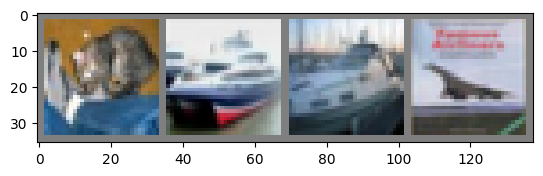

真实标签:  cat   ship  ship  plane


In [210]:
images, labels = next(iter(testloader))

# print images
imshow(torchvision.utils.make_grid(images))
print('真实标签: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

### 导入我们刚刚保存的模型

In [211]:
cnn = CNN()
cnn.load_state_dict(torch.load(PATH))

<All keys matched successfully>

### 使用CNN模型预测

In [213]:
# output代表每个image属于10个类别的分别概率，
outputs = cnn(images)
outputs

tensor([[-0.6495, -1.1622,  0.3942,  1.3310,  1.1498,  0.8790, -0.6018,  1.1651,
         -1.0850, -1.0014],
        [ 3.2479,  5.8777, -1.5823, -2.6425, -2.7502, -3.8079, -2.9400, -3.9557,
          3.5704,  4.5915],
        [ 1.7253,  4.1359, -0.7245, -1.1500, -1.9616, -2.3680, -1.4687, -2.2806,
          2.1279,  2.7783],
        [ 5.5483,  0.9032,  1.9929, -1.3163,  0.1270, -3.0843, -2.7394, -3.2047,
          2.2500,  0.0772]], grad_fn=<AddmmBackward0>)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [214]:
_, predicted = torch.max(outputs, dim=1)  # 每行的最大值

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   car   car   plane


In [215]:
predicted

tensor([3, 1, 1, 0])

### 在全体测试集上的表现

The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [219]:
labels

tensor([3, 5, 1, 7])

In [216]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = cnn(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 52 %


In [218]:
# 将只包含一个元素的tensor转换为标量，无论维数多少都可以转换
print(predicted[0].item(), torch.tensor([[1]]).item())

3 1


### 在不同类别上的表现对比

That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [202]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = cnn(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 47.9 %
Accuracy for class: car   is 70.2 %
Accuracy for class: bird  is 51.3 %
Accuracy for class: cat   is 38.1 %
Accuracy for class: deer  is 43.3 %
Accuracy for class: dog   is 49.4 %
Accuracy for class: frog  is 63.1 %
Accuracy for class: horse is 48.8 %
Accuracy for class: ship  is 71.3 %
Accuracy for class: truck is 59.3 %


## 在GPU上训练

Okay, so what next?

How do we run these neural networks on the GPU?

## Training on GPU
Just like how you transfer a Tensor onto the GPU, you transfer the neural
net onto the GPU.

Let's first define our device as the first visible cuda device if we have
CUDA available:



In [203]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


The rest of this section assumes that ``device`` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:

.. code:: python

    net.to(device)


Remember that you will have to send the inputs and targets at every step
to the GPU too:

.. code:: python

        inputs, labels = data[0].to(device), data[1].to(device)

Why don't I notice MASSIVE speedup compared to CPU? Because your network
is really small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

## Training on multiple GPUs
If you want to see even more MASSIVE speedup using all of your GPUs,
please check out :doc:`data_parallel_tutorial`.

## Where do I go next?

-  :doc:`Train neural nets to play video games </intermediate/reinforcement_q_learning>`
-  `Train a state-of-the-art ResNet network on imagenet`_
-  `Train a face generator using Generative Adversarial Networks`_
-  `Train a word-level language model using Recurrent LSTM networks`_
-  `More examples`_
-  `More tutorials`_
-  `Discuss PyTorch on the Forums`_
-  `Chat with other users on Slack`_




## 参考链接

[torch.nn](https://pytorch.org/docs/stable/nn.html)<br>
[torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d)<br>
[torch.nn.MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d)<br>
[torch.max](https://pytorch.org/docs/stable/generated/torch.max.html#torch-max)